# Step1: Creating Second Quantistion Hamiltonian
Example: $C_2H_4$ Molecule

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pyscf import ao2mo, fci, gto, mcscf, scf, tools
from qiskit.quantum_info import SparsePauliOp


def cholesky(V, eps):
    # see https://arxiv.org/pdf/1711.02242.pdf section B2
    # see https://arxiv.org/abs/1808.02625
    # see https://arxiv.org/abs/2104.08957
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r]
                + C[ncas + p] @ D[ncas + r]
                + C[r] @ D[p]
                + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [2]:
distance = 0.74 # in Angstrom
mol = gto.Mole() # gto = gaussian type orbital
mol.build(
    atom='c2h4.xyz',
    basis="sto-3g",
    spin=0,
    charge=0,
    symmetry=True,
)
print(mol.groupname)
print(mol.irrep_name)


D2h
['Ag', 'B1g', 'B3g', 'B1u', 'B2u', 'B3u']


RHF is a method that finds an approximate ground state energy by assuming electrons are independent and move in an average field (a single Slater determinant).

In [3]:
mf = scf.RHF(mol) # Setting up Restricted Hartree-Fock Calculation
E1 = mf.kernel() # Runs RHF calculation
print(f"Grounf state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
mf.analyze()


converged SCF energy = -77.0720894366185
Grounf state energy by RHF = -77.07208943661851 Hartree = -2097.239454495601 eV
Wave-function symmetry = Ag
occupancy for each irrep:     Ag  B1g  B3g  B1u  B2u  B3u
                               3    1    0    1    2    1
**** MO energy ****
MO #1 (Ag #1), energy= -11.0196614275985 occ= 2
MO #2 (B2u #1), energy= -11.0188896711418 occ= 2
MO #3 (Ag #2), energy= -0.976037099380334 occ= 2
MO #4 (B2u #2), energy= -0.743602989950231 occ= 2
MO #5 (B3u #1), energy= -0.60172388660576 occ= 2
MO #6 (Ag #3), energy= -0.528045032291893 occ= 2
MO #7 (B1g #1), energy= -0.462687390804599 occ= 2
MO #8 (B1u #1), energy= -0.323081777415928 occ= 2
MO #9 (B3g #1), energy= 0.317430713436986 occ= 0
MO #10 (B3u #2), energy= 0.630961212391424 occ= 0
MO #11 (Ag #4), energy= 0.68672960771522 occ= 0
MO #12 (B2u #3), energy= 0.691159122278349 occ= 0
MO #13 (B1g #2), energy= 0.93957476515305 occ= 0
MO #14 (B2u #4), energy= 0.978147726762423 occ= 0
 ** Mulliken atomic charg

((array([1.99982852, 1.03311005, 1.02444972, 1.01705199, 1.        ,
         1.99982852, 1.03311005, 1.02444972, 1.01705199, 1.        ,
         0.96277986, 0.96277986, 0.96277986, 0.96277986]),
  array([-0.07444028, -0.07444028,  0.03722014,  0.03722014,  0.03722014,
          0.03722014])),
 array([-2.82190539e-15, -2.20461359e-16,  0.00000000e+00]))

## nelecas (Number of active electrons)
 nelecas = number of active electrons = usually total number of valence electrons

 format = (num_spin_up, num_spin_down)
 For a standard calculation (singlet, spin=0), these are just (TotalActive / 2, TotalActive / 2).

for $H_2$ (1,1)

## ncas (Number of Active Orbitals)
 ncas must be large enough to hold all the active electrons

 ### Strategy 1: Full Valence Active Space (FVAS)
 This is the most common and robust starting point.
 
 Rule: Include all molecular orbitals (MOs) that are formed from the valence atomic orbitals (AOs).

 ### Strategy 2: Minimal "Interesting" Space
 For quantum computing (VQE), FVAS is often too large. You want the smallest possible space that captures the physics.
 
 Rule: Pick only the orbitals directly involved in a process.

 LiH example used ncas=5! This means the person who wrote it chose a larger space, likely the $\sigma$, $\sigma^*$, and the 3 p-orbitals from the Li atom, to get a more accurate result. This was a chemical choice.

## cas_space_symmetry (The Practical Tool)
This argument is just a tool to select the ncas orbitals you chose in the previous step. It's more reliable than just picking by energy because orbital energies can be in the "wrong" order.
run mf.analyze() to get the orbitals for cas_space_symmetry


In [4]:
nelecas = (2,2)
ncas = 4
cas_space_symmetry = {
    'B3u': 1,   # π
    'B3g': 1,   # π*
    'B1g': 1,   # σ
    'Ag':  1    # σ*
}

mx = mcscf.CASCI(mf, ncas = ncas, nelecas=nelecas)
mo = mcscf.sort_mo_by_irrep(mx, mf.mo_coeff, cas_space_symmetry)

E2 = mx.kernel(mo)[:2] # second value is active_space_energy
h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)
print(f"Ground state energy by RHF = {E1} Hartree = {E1*27.2114} eV")
print(f"Ground State Energy level CASCI = {E2[0]} Hartree = {E2[0]*27.2114} eV")

CASCI E = -76.4553974004251  E(CI) = -3.33930680115535  S^2 = 0.0000000
Ground state energy by RHF = -77.07208943661851 Hartree = -2097.239454495601 eV
Ground State Energy level CASCI = -76.45539740042511 Hartree = -2080.458400821928 eV


In [5]:
H = build_hamiltonian(ecore, h1e, h2e)

accuracy of Cholesky decomposition  1.1102230246251565e-16


# VQE for Ground State Energy

In [6]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp

print(H.num_qubits)

8


9


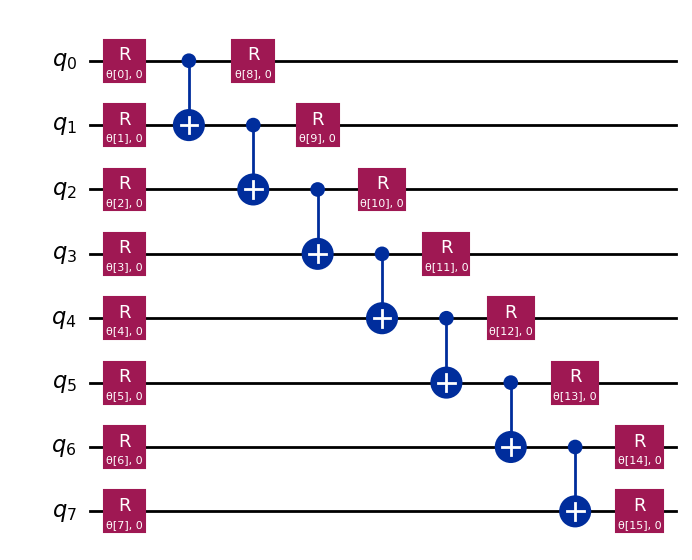

In [7]:
# Pre-defined ansatz circuit
from qiskit.circuit.library import efficient_su2
from scipy.optimize import minimize
# Random initial state and efficient_su2 ansatz
ansatz = efficient_su2(H.num_qubits, su2_gates=["rx"], entanglement="linear", reps=1)
x0 = 2 * np.pi * np.random.random(ansatz.num_parameters)
print(ansatz.decompose().depth())
ansatz.decompose().draw("mpl")

In [8]:
# We will start by using a local simulator
from qiskit_aer import AerSimulator
from qiskit.primitives import BackendEstimatorV2

backend = AerSimulator()
estimator = BackendEstimatorV2(backend = backend)

In [16]:
from scipy.optimize import minimize
import time

# =========================
# USER SETTINGS
# =========================
n_runs = 5
maxiter = 50

# =========================
# COST FUNCTION FACTORY (to log history)
# =========================
def make_cost_func(ansatz, H, estimator, energy_history):
    def cost_func(params):
        pub = (ansatz, [H], [params])
        result = estimator.run(pubs=[pub]).result()
        energy = float(result[0].data.evs[0])

        energy_history.append(energy)   # ✅ LOG EACH ITERATION

        return energy
    return cost_func

# =========================
# STORAGE
# =========================
final_energies = {
    "COBYLA": [],
    "SLSQP": []
}

runtimes = {
    "COBYLA": [],
    "SLSQP": []
}

energy_histories = {
    "COBYLA": [],   # list of lists
    "SLSQP": []
}


In [17]:

# =========================
# COBYLA RUNS (WITH HISTORY)
# =========================
print("Starting COBYLA runs...")

for i in range(n_runs):
    x0_run = np.array(x0)   # ✅ NO perturbation

    energy_history = []    # ✅ per-run history
    cost = make_cost_func(ansatz, H, estimator, energy_history)

    t0 = time.time()
    try:
        res = minimize(
            cost,
            x0_run,
            method="cobyla",
            options={"maxiter": maxiter, "disp": False},
        )
        final_e = float(res.fun)
    except Exception as e:
        print(f"COBYLA run {i+1} crashed: {e}")
        final_e = float(cost(x0_run))

    t1 = time.time()

    final_energies["COBYLA"].append(final_e)
    runtimes["COBYLA"].append(t1 - t0)
    energy_histories["COBYLA"].append(energy_history)

    print(f"  COBYLA run {i+1:3d}/{n_runs}  final E = {final_e:.10f}")


Starting COBYLA runs...
  COBYLA run   1/5  final E = -75.6149781529
  COBYLA run   2/5  final E = -75.9289925990
  COBYLA run   3/5  final E = -75.2716188138
  COBYLA run   4/5  final E = -75.5981704461
  COBYLA run   5/5  final E = -75.9603971313


In [32]:

# =========================
# SLSQP RUNS (WITH HISTORY)
# =========================
maxiter=5
print("\nStarting SLSQP runs...")

for i in range(n_runs):
    x0_run = np.array(x0)   # ✅ NO perturbation

    energy_history = []    # ✅ per-run history
    cost = make_cost_func(ansatz, H, estimator, energy_history)

    t0 = time.time()
    try:
        res = minimize(
            cost,
            x0_run,
            method="slsqp",
            options={"maxiter": maxiter, "ftol": 0.5, "disp": False},
        )
        final_e = float(res.fun)
    except Exception as e:
        print(f"SLSQP run {i+1} crashed: {e}")
        final_e = float(cost(x0_run))

    t1 = time.time()

    final_energies["SLSQP"].append(final_e)
    runtimes["SLSQP"].append(t1 - t0)
    energy_histories["SLSQP"].append(energy_history)

    print(f"  SLSQP run {i+1:3d}/{n_runs}  final E = {final_e:.10f}")



Starting SLSQP runs...
  SLSQP run   1/5  final E = -74.8106713063
  SLSQP run   2/5  final E = -75.1432262787
  SLSQP run   3/5  final E = -74.8537114723
  SLSQP run   4/5  final E = -74.9887485394
  SLSQP run   5/5  final E = -74.8550395500


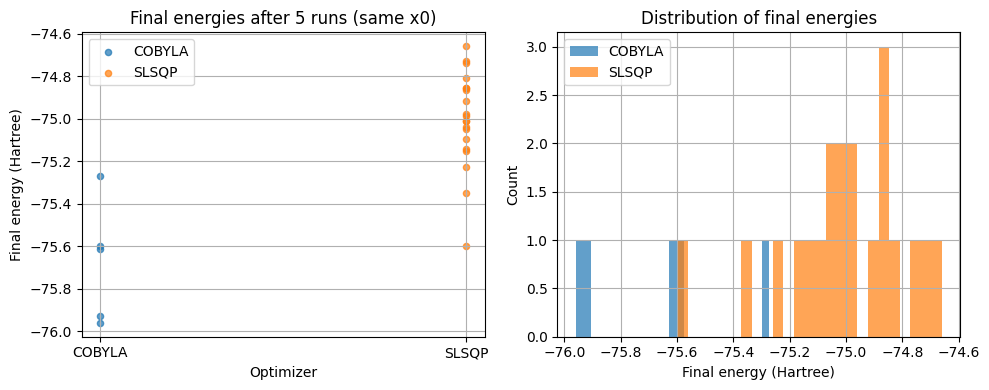


Summary statistics:
COBYLA  | mean = -75.6748314286 | std = 2.523e-01 | best = -75.9603971313
SLSQP   | mean = -75.0036178073 | std = 2.184e-01 | best = -75.5972118080


In [33]:


# =========================
# SCATTER + HISTOGRAM PLOTS
# =========================
plt.figure(figsize=(10,4))

# ---- Scatter ----
plt.subplot(1,2,1)
optimizers = list(final_energies.keys())

for i, opt_name in enumerate(optimizers):
    y = final_energies[opt_name]
    x = np.full_like(y, i, dtype=float)
    plt.scatter(x, y, alpha=0.7, s=20, label=opt_name)

plt.xticks(range(len(optimizers)), optimizers)
plt.ylabel("Final energy (Hartree)")
plt.xlabel("Optimizer")
plt.title(f"Final energies after {n_runs} runs (same x0)")
plt.grid(True)
plt.legend()

# ---- Histogram ----
plt.subplot(1,2,2)
bins = 25
plt.hist(final_energies["COBYLA"], bins=bins, alpha=0.7, label="COBYLA")
plt.hist(final_energies["SLSQP"], bins=bins, alpha=0.7, label="SLSQP")
plt.xlabel("Final energy (Hartree)")
plt.ylabel("Count")
plt.title("Distribution of final energies")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# =========================
# NUMERICAL SUMMARY
# =========================
print("\nSummary statistics:")
for opt_name in optimizers:
    arr = final_energies[opt_name]
    print(
        f"{opt_name:7s} | mean = {np.mean(arr):.10f} | "
        f"std = {np.std(arr):.3e} | best = {np.min(arr):.10f}"
    )


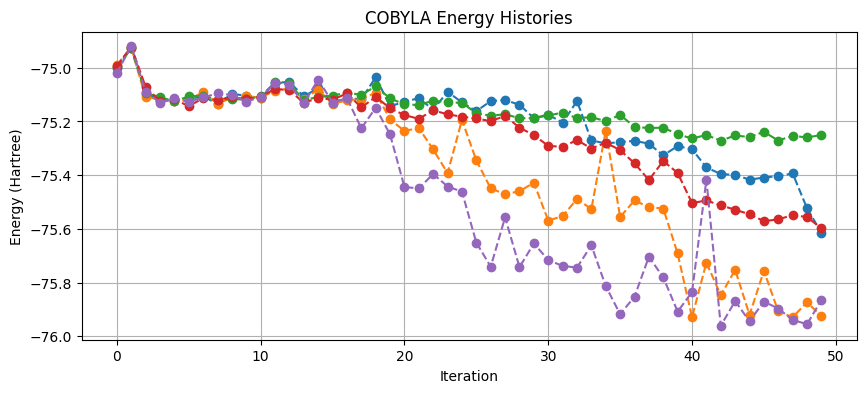

In [22]:

plt.figure(figsize=(10, 4))

# =========================
# COBYLA ENERGY HISTORIES
# =========================


for hist in energy_histories["COBYLA"]:
    plt.plot(hist,'o--')

plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("COBYLA Energy Histories")
plt.grid(True)


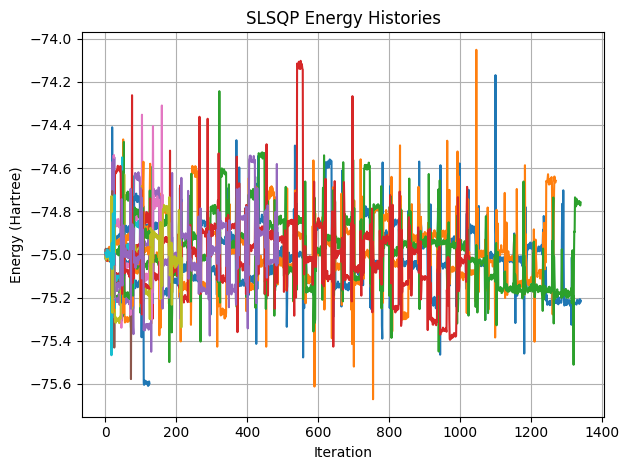

In [34]:

# =========================
# SLSQP ENERGY HISTORIES
# =========================


for hist in energy_histories["SLSQP"]:
    plt.plot(hist)

plt.xlabel("Iteration")
plt.ylabel("Energy (Hartree)")
plt.title("SLSQP Energy Histories")
plt.grid(True)

plt.tight_layout()
plt.show()